# G2P

### Grapheme to phoneme conversion with the cmudict dataset

Inspired by Ben Trevett's excellent [tutorial](https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb) on seq2seq learning.


In [1]:
!pip install textdistance # to calculate phoneme error rate

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import re 
import random
import math
import time
import textdistance
import matplotlib.pyplot as plt

## 1. Preprocess the data + Custom dataloader and collate function

Set seed for determinic results.

In [3]:
SEED = 42

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

We create a custom Dataset class to pass our datasplits (see below) to pytorch's DataLoader.

In [4]:
class Subset(Dataset):
    """
    A custom Subset class to pass to DataLoader.
    
    Args:
        data (list): numericalized data pairs
        source_field (Field): converts a source example back into a word
        target_field (Field): converts a target example back into phonemes
    """
    def __init__(self, data, source_field, target_field):
        self.data = data
        self.source_field = source_field
        self.target_field = target_field
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]
    
    def to_string(self, index):
        """Converts an example pair back into string."""
        
        source, target = self.data[index]
        decoded_source = self.source_field.tensor_to_string(source, datatype='chars')
        decoded_target = self.target_field.tensor_to_string(target, datatype='phonemes')
        return decoded_source, decoded_target

This Field class handles source and target data to convert strings to tensors according to a vocabulary mapping (built from the training data only). 

In [5]:
class Field:
    """
    A Field class to create a vocabulary and numericalize data.
    Args:
        string2int (dict): mapping from string to indices
        data (list): example strings (words or phonemes)
    """
    def __init__(self, data):
        self.string2int = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.data = data
    
    def __len__(self):
        return len(self.string2int)
    
    def build_vocab(self, data):
        idx = 4
        for string in data:
            for char in string:
                if not char in self.string2int:
                    self.string2int[char] = idx
                    idx += 1               
        self.int2string = {v: k for k, v in self.string2int.items()}
        
    def string_to_tensor(self, string):
        """Converts a string according to the vocabulary and adds special tokens."""
        
        int_string = [self.string2int["<SOS>"]]
        int_string.extend([self.string2int[char] if char in self.string2int 
                             else self.string2int["<UNK>"] for char in string])
        int_string.append(self.string2int["<EOS>"])
        tensor = torch.LongTensor(int_string)
        return tensor   
    
    def tensor_to_string(self, tensor, datatype):
        """Translates a tensor mapping back into text."""
        
        if datatype == 'chars':
            return "".join(self.int2string[int(i.item())] for i in tensor if not i in [0, 1, 2])
        else:
            return " ".join(self.int2string[int(i.item())] for i in tensor if not i in [0, 1, 2])

The GraphemesDataset class:
 - loads the data, preprocesses it and shuffles it
 - partitions the numericalized data into a train/dev/test split (as our custom Subset class)

In [6]:
class GraphemesDataset:
    """
    A class to load the data and create numericalized data splits.
    Args:
        dict_file (str): path to data file
        split (list): proportions to split the data into train/dev/test
    """
    def __init__(self, dict_file, split):
        self.dict_file = dict_file
        self.split = split
        self.data = self._get_data(dict_file)
        random.shuffle(self.data)        
        self.source_field = Field([ex[0] for ex in self.data])
        self.target_field = Field([ex[1] for ex in self.data])
        self.train_data, self.valid_data, self.test_data = self._split_dataset()
        self._build_vocab(self.train_data)
                    
    def _get_data(self, dict_file):
        """Retrieves source and target data for a file and preprocesses it."""
        
        data_pairs = []
        with open(dict_file, 'r') as f:
            for line in f.readlines():
                word = line.strip().split()[0] 
                if not re.search('(\d)', word): # ignore repeated samples
                    line = line.strip().split(' # ')[0] # remove content with #
                    ex_source, ex_target = line.split(' ', 1) 
                    data_pairs.append((ex_source, ex_target.split()))
        return data_pairs
    
    def _split_dataset(self):
        """Splits the data according to the defined proportions."""
        
        train, valid, test = self.split
        train_index = int(len(self.data) * train)
        valid_index = train_index + int(len(self.data) * valid)
        train_data = []
        valid_data = []
        test_data = []
        for idx, (source_ex, target_ex) in enumerate(self.data):
            if idx < train_index:
                train_data.append((source_ex, target_ex))
            elif train_index <= idx < valid_index:
                valid_data.append((source_ex, target_ex))
            else:
                test_data.append((source_ex, target_ex))
        return train_data, valid_data, test_data
    
    def _build_vocab(self, train_data):
        """Builds vocabulary mappings for source and target."""
        
        source = [ex[0] for ex in train_data]
        target = [ex[1] for ex in train_data]
        self.source_field.build_vocab(source)
        self.target_field.build_vocab(target)
        
    def _to_tensor(self, pair):
        """Converts a string to a tensor according to the vocabulary."""
        
        source, target = pair
        encoded_source = self.source_field.string_to_tensor(source)
        encoded_target = self.target_field.string_to_tensor(target)
        return encoded_source, encoded_target 

    def get_transformed_data_splits(self):
        """Gets numericalized Subsets from the data splits for DataLoader."""
        
        train_data = Subset([self._to_tensor(ex) for ex in self.train_data], 
                               self.source_field, self.target_field)
        valid_data = Subset([self._to_tensor(ex) for ex in self.valid_data],
                               self.source_field, self.target_field)
        test_data = Subset([self._to_tensor(ex) for ex in self.test_data],
                              self.source_field, self.target_field)
        return train_data, valid_data, test_data       

We use a custom collate function for the Dataloader which pads sequences according to the longest sequence in a batch.

In [7]:
class PadCollate:
    """
    A custom Collate class to pass as collate_fn to DataLoader.
    """
    def __init__(self, dim=0):
        self.dim = dim

    def _pad_collate(self, batch):
        # find longest sequence
        max_len_source = max(map(lambda x: x[0].shape[self.dim], batch))
        max_len_target = max(map(lambda x: x[1].shape[self.dim], batch))
        max_len = max((max_len_source, max_len_target))
        # pad according to max_len
        source = [self.pad_tensor(source, pad=max_len) for source, target in batch] 
        target = [self.pad_tensor(target, pad=max_len) for source, target in batch]
        # stack all
        src = torch.stack(source, dim=1)
        trg = torch.stack(target, dim=1)
        return src, trg

    def pad_tensor(self, vec, pad):
        """
        Args:
            vec - tensor to pad
            pad - the size to pad to
        Return:
            a new tensor padded to 'pad' in dimension 'dim'
        """
        pad_size = list(vec.shape)
        pad_size[self.dim] = pad - vec.size(self.dim)
        return torch.cat([vec, torch.zeros(*pad_size).long()], dim=self.dim)

    def __call__(self, batch):
        return self._pad_collate(batch)

In [8]:
BATCH_SIZE = 64
NUM_WORKERS = 2
dict_file = "cmudict.dict"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = GraphemesDataset(dict_file=dict_file, split=[0.85, 0.05, 0.1])
train_data, valid_data, test_data = dataset.get_transformed_data_splits()

train_iterator = DataLoader(train_data, shuffle=True, num_workers=NUM_WORKERS, drop_last=True,  
                            batch_size=BATCH_SIZE, collate_fn=PadCollate(), pin_memory=True)
valid_iterator = DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=PadCollate(), drop_last=True)
test_iterator = DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=PadCollate(), drop_last=True)

In [9]:
source_vocab = dataset.source_field.int2string
target_vocab = dataset.target_field.int2string

In [10]:
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 107138
Number of validation examples: 6302
Number of testing examples: 12605


Subset method to check an example at a given index:

In [11]:
print(train_data.to_string(1))

('radiography', 'R EY2 D IY0 AA1 G R AH0 F IY0')


In [12]:
print(f"Unique tokens in source (characters) vocabulary: {len(dataset.source_field)}")
print(f"Unique tokens in target (phonemes) vocabulary: {len(dataset.target_field)}")

Unique tokens in source (characters) vocabulary: 33
Unique tokens in target (phonemes) vocabulary: 73


## 3. Model definition

In [13]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell

In [14]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
                
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell


In [15]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

## 4. Hyperparameters and training parameters

In [16]:
INPUT_DIM = len(dataset.source_field)
OUTPUT_DIM = len(dataset.target_field)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

In [17]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(33, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(73, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=73, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 7,421,001 trainable parameters


In [19]:
optimizer = optim.Adam(model.parameters())

In [20]:
PAD_IDX = dataset.source_field.string2int["<PAD>"]

criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

## 5. Training loop

In [21]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src, trg = batch

        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output = model(src.long(), trg.long())
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

### Evaluation

We use the following common evaluation metrics for G2P task, taken from the paper "Transformer based Grapheme-to-Phoneme Conversion" by Yolchuyeva, Németh, Gyires-Tóth, Interspeech 2019:

- Phoneme Error Rate (PER): Levenshtein distance between the predicted phoneme sequence and the target sequence, divided by  the number of phonemes in the target pronunciation; this is done with all target-prediction pairs, and an average is then computed.
- Word Error Rate (WER): percentage of words in which the  predicted phoneme sequence does not exactly match the target pronunciation; the number of word errors is divided by the number of test samples.

We use a flag `test` to differenciate between evaluation and test mode. In test mode, each test example is fed into a softmax to have a probability distribution over the target vocabulary. We retrieve the most likely candidate using `argmax`. 

In [22]:
def evaluate(model, iterator, criterion, test):
    
    model.eval()
    softmax = torch.nn.Softmax(dim=0)
    
    epoch_loss = 0
    wer_count = 0 # count to calculate word error rate
    levenshtein_scores = [] # list to calculate phoneme error rate
    predictions = []
    
    with torch.no_grad():
            
        for batch in iterator:

            src, trg = batch
            src = src.to(device)
            trg = trg.to(device)

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            # reshape data for evaluation of each test example
            trg_T = torch.transpose(trg, 0, 1) 
            output_T = torch.transpose(output, 0, 1)

            for target_seq, output_seq in zip(trg_T, output_T):
                
                #target_seq = [trg len]
                #output_seq = [trg len, output dim]

                # flags to signal when both target and output sequences are over
                # i.e. ignore padding
                trg_stopped = False 
                output_stopped = False

                decoded_target_seq  = []
                decoded_output_seq = []                

                for y, pred in zip(target_seq[1:], output_seq[1:]): # ignore <SOS>

                    #y = single value
                    #pred = [output dim]

                    pred = softmax(pred)
                    y_hat = torch.argmax(pred)

                    if not output_stopped and target_vocab[y_hat.item()] == '<EOS>':
                        output_stopped = True
                    if not trg_stopped and target_vocab[y.item()] == '<EOS>':
                        trg_stopped = True 
                    if output_stopped and trg_stopped:
                        break

                    y = target_vocab[y.item()]
                    y_hat = target_vocab[y_hat.item()]

                    decoded_target_seq.append(y)
                    decoded_output_seq.append(y_hat)

                predictions.append(' '.join(decoded_target_seq) + '\t' + 
                                   ' '.join(decoded_output_seq))

                # WER
                if decoded_target_seq != decoded_output_seq:
                    wer_count += 1

                # PER
                seq_len = target_seq[1:].tolist().index(2) # 2: <EOS>
                levenshtein_scores.append(
                    textdistance.levenshtein.distance(
                        decoded_target_seq, decoded_output_seq) / seq_len)
                
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    if test: # write to file for qualitative analysis

        with open('predictions.tsv', 'w') as ostr:
            for pred in predictions:
                print(pred, file=ostr)

        WER = wer_count / len(test_data)    
        PER = sum(levenshtein_scores) / len(levenshtein_scores)

        return (epoch_loss / len(iterator)), WER, PER

    return epoch_loss / len(iterator)

In [23]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [24]:
N_EPOCHS = 20
CLIP = 1

best_valid_loss = float('inf')

train_losses = []
valid_losses = []

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion, test=False)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss: # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'g2p-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 1m 7s
	Train Loss: 2.008 | Train PPL:   7.452
	 Val. Loss: 0.995 |  Val. PPL:   2.704
Epoch: 02 | Time: 1m 7s
	Train Loss: 0.644 | Train PPL:   1.904
	 Val. Loss: 0.612 |  Val. PPL:   1.844
Epoch: 03 | Time: 1m 8s
	Train Loss: 0.451 | Train PPL:   1.570
	 Val. Loss: 0.515 |  Val. PPL:   1.674
Epoch: 04 | Time: 1m 6s
	Train Loss: 0.375 | Train PPL:   1.455
	 Val. Loss: 0.467 |  Val. PPL:   1.596
Epoch: 05 | Time: 1m 7s
	Train Loss: 0.327 | Train PPL:   1.387
	 Val. Loss: 0.446 |  Val. PPL:   1.561
Epoch: 06 | Time: 1m 7s
	Train Loss: 0.295 | Train PPL:   1.343
	 Val. Loss: 0.424 |  Val. PPL:   1.528
Epoch: 07 | Time: 1m 6s
	Train Loss: 0.265 | Train PPL:   1.303
	 Val. Loss: 0.416 |  Val. PPL:   1.516
Epoch: 08 | Time: 1m 8s
	Train Loss: 0.245 | Train PPL:   1.277
	 Val. Loss: 0.415 |  Val. PPL:   1.515
Epoch: 09 | Time: 1m 7s
	Train Loss: 0.225 | Train PPL:   1.252
	 Val. Loss: 0.399 |  Val. PPL:   1.490
Epoch: 10 | Time: 1m 6s
	Train Loss: 0.208 | Train PPL:   1.231


Plotting train and validation losses over epochs.

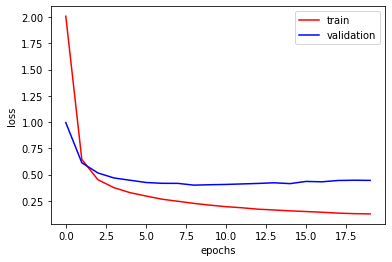

In [25]:
plt.plot(train_losses, 'r', label="train")
plt.plot(valid_losses, 'b', label="validation")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc="upper right")
 
plt.show()

## 6. Evaluate the model on test data

In [26]:
model.load_state_dict(torch.load('g2p-model.pt'))

<All keys matched successfully>

In [27]:
test_loss, WER, PER = evaluate(model, test_iterator, criterion, test=True)
print(f'| Word Error Rate: {WER:.3f} |')
print(f'| Phoneme Error Rate: {PER:.3f} |')
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Word Error Rate: 0.374 |
| Phoneme Error Rate: 0.109 |
| Test Loss: 0.420 | Test PPL:   1.521 |
